In [247]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

Partie 2 i)

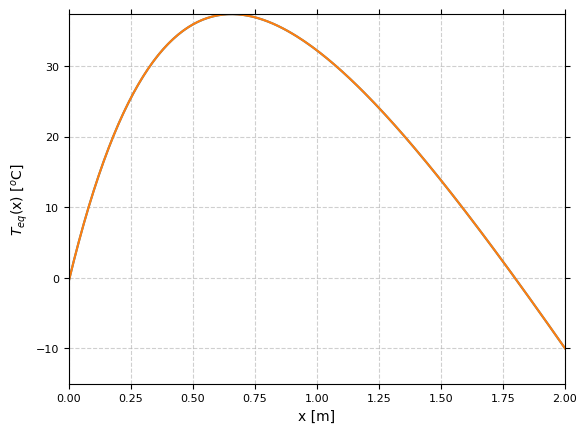

L'erreur sur la valeur de température maximale à l'équilibre est : 0.0035 °C


In [248]:
"""
Code de la partie 2 i). Il y est présenté un graphique de la température à équilibre
en fonction de la température ainsi que la température maximale à l'équilibre et son erreur associée
"""

# Équation différentielle: d^2 u/dx^2=g(x) sur x=(a,b)
# Conditions aux limites générales:
# x=a: c1*du/dx+c2*u+c3=0
# x=b: d1*du/dx+d2*u+d3=0

# Équation de transfert de chaleur d^2 T/dx^2=-S(x)/k sur x=(0,L)
# dans un mur d'isolation thermique
L=2 #[m] ; Épaisseur du mur

k=1;h=10
#[W/(m*K)]; La conductivité thermique de la brique
#[W/(m^2*K)]; Coefficient de transfert thermique pour l'interface plane entre l'air et solide.


# Condition convective (de Robin) à x=0 (face externe du mur): -k*dT/dx=h(Ta-T)
Ta=-15; #[oC]
c1=-k; c2=h; c3=-h*Ta
# Condition de Neumann à x=L (face interne du mur): dT/dx=0 - flux net de chaleur est 0
d1=-k; d2=-h; d3=h*Ta

#(N+1) nœuds dans la maille
# Nmax=10000 pour 1G de mémoire

Nar1 = np.array([200,400]); #dx= 1cm
#Nar1= np.concatenate((np.arange(2, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100), np.arange(2000, 6000, 1000))); # Matrice pleine
 
Nar=np.zeros(2*Nar1.size,dtype=Nar1.dtype);
Nar[np.arange(0,2*Nar1.size-1,2)]=Nar1.copy();
Nar[np.arange(0,2*Nar1.size-1,2)+1]=2*Nar1.copy();

ci=-1;
Err=np.zeros(Nar1.size,dtype=np.double);
tInv=np.zeros(Nar.size,dtype=np.double);
Tmax=np.zeros(Nar.size,dtype=np.double);

plt.figure(1)
for N in Nar1:
    S=np.zeros(N+1,dtype=np.double);
    A=np.zeros((N+1,N+1),dtype=np.double);
    b=np.zeros(N+1,dtype=np.double);
    u=np.zeros(N+1,dtype=np.double);
    
    ci=ci+1;
    dx=L/N; #Pas de discrétisation
    x=np.linspace(0,L,N+1)
    
    # Sourse volumique de chaleur q[W/m^3] d'épaisseur dL
    # La source est intégrée dans la partie intérieure du mur
    dL=0.5; 
    q=400; # W/m^3;
    S=q*np.exp(-x/dL)
    

    # matrice pleine
    A = np.diag(-2*np.ones(N+1),0)+np.diag(np.ones(N),-1)+np.diag(np.ones(N),1)
    
    A[0,0]=2*c2*dx-3*c1;A[0,1]=4*c1;A[0,2]=-c1
    A[N,N]=3*d1+2*d2*dx;A[N,N-1]=-4*d1;A[N,N-2]=d1
    b=-S/k*dx**2; b[0]=-2*c3*dx; b[N]=-2*d3*dx
    
    tic=time.time_ns()
    u=np.linalg.solve(A, b); # Option préférée
#    u=np.linalg.inv(A)@b; # Option gourmande en mémoire
    toc=time.time_ns()
    tInv[ci]=(toc-tic)/1e9 #temps en [s]   
    
    Tmax[ci]=u.max()
    plt.plot(x,u)
    
plt.axis([x[0], x[-1], Ta, Tmax.max()])
plt.xlabel('x [m]')    
plt.ylabel('$T_{eq}$(x) [$^o$C]')
ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=True, labelsize=8)
ax.tick_params(axis='y', which='both', left=True, right=True, labelsize=8)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.show()

Err = np.abs(Tmax[np.arange(0,Tmax.size,2)]-Tmax[np.arange(1,Tmax.size,2)])
Err_arondi = np.round(Err, 4)
print(f"L'erreur sur la valeur de température maximale à l'équilibre est : {Err_arondi[0]} °C")





Tmax_eq=Tmax[-2]
# print('N=',Nar1[-1],'Tmax=',Tmax_eq)


Partie 1 et partie 2 ii)

In [249]:
"""
Code de la partie 1 et de la partie ii). Un algorithme est développé pour la résolution temporelle
de l'équation de la chaleur. Cet algorithme est ensuite utilisé pour calculer le temps d'équilibrage du système
"""

#Constantes

L = 2 #[m]
dL= 0.5
q = 400 # [W/m^3]
Ta = 258.15 # [Kelvin]
i = 200 # Nombre de pas du maillage spatial [s]
dx=L/i; #Pas de discrétisation
ti = 0 # temps initial [s]
tf = 10**7 # temps final [s]

k = 1 # [W/(m*K)]
h = 10 # [W/(m^2*K)]
Xi = 0.75 # [S.U.]
Cv = 1000 # [J/(Kg*K)]
rho = 2000 # [Kg/m^3]
dt = dx**2*((Cv*rho)/k) # pas de temps [s]

In [250]:
#Conditions frontieres
# à x=0 : c1*T'(0)+c2*T(0) + c3 = 0 ; à x=L d1*T'(L) + d2*T(L) + d3 = 0
c1, c2, c3 = -k, h, -h*Ta
d1, d2, d3 = -k, -h, h*Ta

In [251]:
#Initialisations des matrices
S=np.zeros(i+1,dtype=np.double)
A=np.diag(-2*np.ones(i+1),0)+np.diag(np.ones(i),-1)+np.diag(np.ones(i),1)
b=np.zeros(i+1,dtype=np.double)
u=np.zeros(i+1,dtype=np.double)

#Source
x=np.linspace(0,L,i+1)
S=(q*np.exp(-x/dL))/k
u0=np.full(i+1,Ta,dtype=np.double)

#Conditions frontieres dans la matrice A
A[0, 0], A[0, 1], A[0, 2] = (2*c2 *dx -3*c1)*Xi, 4*c1*Xi, -c1*Xi
A[i, i-2], A[i, i-1], A[i, i] = d1*Xi, -4*d1*Xi, (2*d2*dx+3*d1)*Xi

#Vecteur b et conditions frontieres
b=-S*dx**2
b[0]=-2*c3*dx-(2*c2*dx-3*c1)*(1-Xi)*u0[0]-4*c1*(1-Xi)*u0[1]+c1*(1-Xi)*u0[2] 
b[i]=-2*d3*dx-d1*(1-Xi)*u0[i-2]+4*d1*(1-Xi)*u0[i-1]-(2*d2*dx+3*d1)*(1-Xi)*u0[i]

#Matrice M
M=np.diag(np.ones(i+1))
M[0,0]=0
M[i,i]=0

#A' et B'
alpha = (Cv*rho)/k
A_prime = M-(dt/(alpha*dx**2))*Xi*A
b_prime = (M+(dt/(alpha*dx**2))*(1-Xi)*A)@u0-(dt/(alpha*dx**2))*(Xi*b+(1-Xi)*b)

In [252]:
#Resolution temporelle

t=ti
T_max=[Ta]
ci=1
time_list=[0]

while t<tf:
    
    ci+=1
    u=np.linalg.solve(A_prime,b_prime)
    T_max.append(u.max())
    b_prime = (M+(dt/(alpha*dx**2))*(1-Xi)*A)@u-(dt/(alpha*dx**2))*(Xi*b+(1-Xi)*b)
    time_list.append(t)
    t=t+dt

In [253]:
#Calcul du temps d'équilibre

T_max_K = np.array(T_max) 
T0 = T_max_K[0]
T_eq = T_max_K[-1]

threshold = T0 + 0.95 * (T_eq - T0)

mask = T_max_K >= threshold

if np.any(mask):
    idx = np.argmax(mask)
    tau_eq = time_list[idx]
    print(f"Temps d'équilibrage τ_eq = {tau_eq:.3e} s")
else:
    print("Le seuil d'équilibre n'a pas été atteint pendant la simulation.")

print(f"T0 = {T0-273.15:.2f}, T_eq = {T_eq-273.15:.3f}, threshold = {threshold-273.15:.3f}")
print(f"Max atteint = {np.max(T_max_K)-273.15:.3f}")

Temps d'équilibrage τ_eq = 2.773e+06 s
T0 = -15.00, T_eq = 37.333, threshold = 34.716
Max atteint = 37.333


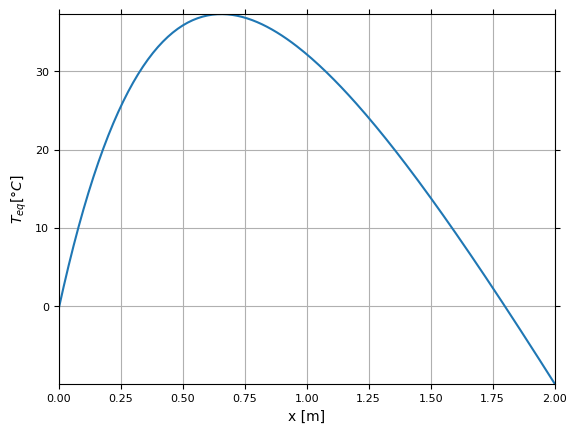

In [254]:
#Graphique temps vs espace

x=np.linspace(0,L,len(u))
u=u-273.15
plt.plot(x,u)
plt.xlabel('x [m]')
plt.ylabel('$T_{eq} [°C]$')
plt.xlim(0,2)
plt.ylim(u.min(),u.max())
ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=True, labelsize=8)
ax.tick_params(axis='y', which='both', left=True, right=True, labelsize=8)
plt.grid()
plt.show()


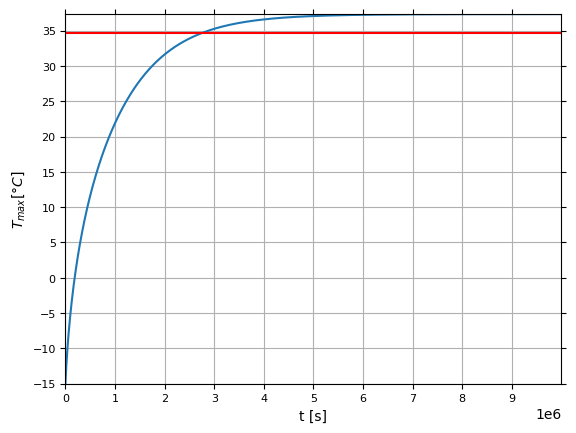

In [255]:
#Graphique tmax temps

T_max=np.array(T_max)-273.15
plt.plot(time_list,T_max)
plt.axhline(threshold-273.15, color="red")
plt.xlabel('t [s]')
plt.ylabel('$T_{max} [°C]$')
plt.xlim(np.array(time_list).min(),np.array(time_list).max())
plt.ylim(T_max.min(),T_max.max())
plt.yticks(np.linspace(-15, 35, 11))
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(10)) 
ax.tick_params(axis='x', which='both', bottom=True, top=True, labelsize=8)
ax.tick_params(axis='y', which='both', left=True, right=True, labelsize=8)
plt.grid()
plt.show()